In [4]:
import huxt as H
import huxt_analysis as HA
import SIR_HUXt as sir

import astropy.units as u
import glob
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as st

from sklearn.neighbors import KernelDensity
from astropy.time import Time

In [5]:
import os
import glob

In [6]:
cwd = os.getcwd()
root = cwd.split('SIR_HUXt')[0]
root = os.path.join(root,'SIR_HUXt')

print(root)

# Find the config.dat file path
files = glob.glob('config.dat')

with open(files[0], 'r') as file:
    lines = file.read().splitlines()
    dirs = {line.split(',')[0]: os.path.join(root, line.split(',')[1]) for line in lines[1:]}
    
print(dirs)


C:\Users\yq904481\research\repos\SIR_HUXt
{'boundary_conditions': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\boundary_conditions', 'ephemeris': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\ephemeris\\ephemeris.hdf5', 'HUXt_data': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\HUXt', 'sir_data': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\sir_analysis', 'HUXt_figures': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\figures'}


In [20]:
cwd = os.getcwd()
root = cwd.split('SIR_HUXt')[0]
root = os.path.join(root,'SIR_HUXt')

paths = {'boundary_conditions':['data','boundary_conditions'],
'ephemeris':['data','ephemeris', 'ephemeris.hdf5'],
'HUXt_data':['data','HUXt'],
'sir_data':['data','sir_analysis'],
'HUXt_figures':['figures']}

paths = {k:os.path.join(root, *v) for k,v in paths.items()}

In [21]:
paths

{'boundary_conditions': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\boundary_conditions',
 'ephemeris': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\ephemeris\\ephemeris.hdf5',
 'HUXt_data': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\HUXt',
 'sir_data': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\sir_analysis',
 'HUXt_figures': 'C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\figures'}

SyntaxError: can't use starred expression here (313862167.py, line 4)

In [12]:
lines[1].split(',')[1].split('\\')

['data', 'boundary_conditions']

(25.0, 40.0)

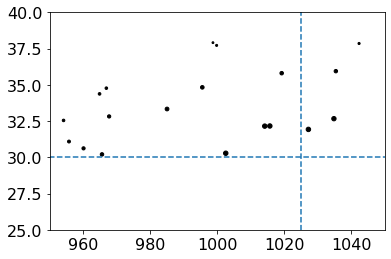

In [31]:
v_true = 1025
wid_true = 30

v = 1000 + np.random.uniform(-1,1,20)*50
wid = 33 + np.random.uniform(-1,1,20)*5

v_weight = st.norm.pdf(v-v_true, loc=0, scale=25)
wid_weight = st.norm.pdf(wid-wid_true, loc=0, scale=2.5)
weight = v_weight*wid_weight


vg = np.linspace(900,1100,200)
wg = np.linspace(25,40,200)
vg, wg = np.meshgrid(vg, wg)

data = np.array([v_z.ravel(), wid_z.ravel()]).T

# Weighted Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(data, sample_weight=weights.ravel())

samp = np.array([vg.ravel(), wid_z.ravel()]).T
scores = kde.score_samples(

fig, ax = plt.subplots()
lgw = np.log(weight)
sz = (lgw - lgw.min())/(lgw.max() - lgw.min())
ax.scatter(v, wid, marker='o', color='k', s=20*sz)
ax.vlines(v_true,20,40,linestyles=['--'])
ax.hlines(wid_true,900,1200,linestyles=['--'])
ax.set_xlim(950,1050)
ax.set_ylim(25,40)



In [ ]:
# Remove any particles with invalid weights
id_good = np.isfinite(weights)
weights = weights[id_good]
v = v[id_good]
wid = wid[id_good]

# Convert speeds to z-scores
v_z, v_avg, v_std = zscore(v)
wid_z, wid_avg, wid_std = zscore(wid)

# Prepare data for KDE
data = np.array([v_z.ravel(), wid_z.ravel()]).T

# Weighted Gaussian KDE
kde = KernelDensity(kernel='gaussian', bandwidth=0.25).fit(data, sample_weight=weights.ravel())

# Resample the particles, and convert back to parameter space from zscore
n_members = parameter_array['n_members']
resample = kde.sample(n_members)
v_z_resamp =  resample[:, 0]
wid_z_resamp =  resample[:, 1]

v_resamp = anti_zscore(v_z_resamp, v_avg, v_std)
wid_resamp = anti_zscore(wid_z_resamp, wid_avg, wid_std)


In [ ]:
start_time = Time('2008-06-30T00:00:00')
model = sir.setup_huxt(start_time, uniform_wind=True)
# Generate a "truth" CME
base_cme = sir.get_base_cme()
model.solve([base_cme])
HA.animate(model, 'irap_example')

In [ ]:
# Test the SIR scheme
np.random.seed(20100114)

start_time = Time('2008-06-30T00:00:00')

for i in range(50):
    
    model = sir.setup_huxt(start_time, uniform_wind=True)

    # Generate a "truth" CME
    base_cme = sir.get_base_cme()
    cme_truth = sir.perturb_cme(base_cme)

    # Get HUXt solution of this truth CME, and observations from L5
    model.solve([cme_truth])
    cme_truth = model.cmes[0]
    hit, t_arrive, t_transit, hit_lon, hit_id = cme_truth.compute_arrival_at_body('EARTH')
    
    observer_lon = -60*u.deg
    L5Obs = sir.Observer(model, cme_truth, observer_lon, el_min=4.0, el_max=30.0)

    model_flank = L5Obs.model_flank
    observed_cme_flank = L5Obs.compute_synthetic_obs(el_spread=0.5, cadence=3, el_min=4.0, el_max=30.0)
    
    observations = {'t_arrive':t_arrive, 't_transit':t_transit, 'observer_lon':observer_lon,
                    'observed_cme_flank':observed_cme_flank, 'cme_params':cme_truth.parameter_array()}
    
    tag = "uniform_weak_run_{:03d}".format(i)
    sir.SIR(model, base_cme, observations, tag)

In [ ]:
weak_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_weak_run*.hdf5")
standard_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_run*.hdf5")
strong_files = glob.glob("C:\\Users\\yq904481\\research\\repos\\SIR_HUXt\\data\\out_data\\SIR_HUXt_uniform_strong_run*.hdf5")

for files in [weak_files, standard_files, strong_files]:
    
    ess_all = []
    rank_hist_data = []
    for f in files:

        out_file = h5py.File(f, 'r')

        pdf_max = []
        ess = []
        for i in range(8):

            key = "analysis_{:02d}".format(i)
            v = out_file[key]['speeds'][:]

            kde = KernelDensity(kernel='gaussian', bandwidth=25).fit(v.reshape(-1,1))
            v_grid = np.arange(800,1200,1)
            log_pdf = kde.score_samples(v_grid.reshape(-1,1))
            pdf = np.exp(log_pdf)
            pdf_max.append(pdf.max())

            w = out_file[key]['weights'][:]
            ess.append(1 / np.sum(w**2))

            if i==7:
                cme_truth_params = out_file['cme_params'][:]
                v_truth = cme_truth_params[4]
                v_all = np.append(v,v_truth)
                v_ranks = st.rankdata(v_all)
                rank_hist_data.append(v_ranks[-1])


        cme_truth_params = out_file['cme_params'][:]
        v_truth = cme_truth_params[4]
        
        cme_truth_params = out_file['cme_params'][:]
        v_truth = cme_truth_params[4]
        v_all = np.append(v,v_truth)
        v_ranks = st.rankdata(v_all)
        rank_hist_data.append(v_ranks[-1])
        ess_all.append(ess[-1])

        out_file.close()
        
    fig, ax = plt.subplots()
    ax.hist(rank_hist_data)
